<h1 style="font-size:40px;"><center>Exercise III:<br> Image Classification using CNNs</center></h1>

In this lab an CNN network to classify rgb images. Image classification refers to classify classes from images. For the dataset in this lab the dataset consist of multiple images but only one are used to classify, the rest are ignored.

The report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report.

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to access the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('..')))

In [2]:
# Torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# local modules
from torch.utils.data import DataLoader
from DL_labs.utils.dataset import SegmentationDataset
from DL_labs.utils import dataloader
from DL_labs.utils.model import Model
from config import flying_objects_config
from collections import OrderedDict
from DL_labs.utils import plot
import pprint

## Load config

In [3]:
cfg = flying_objects_config()

# Example Task
First we present an example task to get an idea of the implementation and how to structure the code.

## Example data
First load the dataloaders for three datasets; train, validation and test.

In [5]:
train_dataloader = DataLoader(SegmentationDataset(cfg.training_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=True,
                        num_workers=cfg.NUM_WORKERS)
valid_dataloader = DataLoader(SegmentationDataset(cfg.validation_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)
test_dataloader = DataLoader(SegmentationDataset(cfg.testing_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

print("Data batch generators are created!")

Data batch generators are created!


## Visualise data
To get an idea of the dataset we visualise the data. 

x (32, 4, 128, 128) torch.float32 0.0 1.0
y (32, 128, 128) torch.int64 0 3


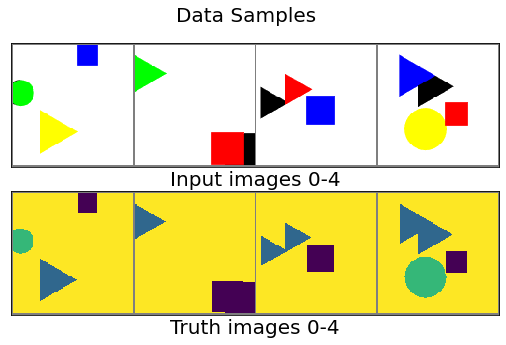

In [6]:
t_x, t_y = next(iter(train_dataloader))
print(f"x {tuple(t_x.shape)} {t_x.dtype} {t_x.min()} {t_x.max()}")
print(f"y {tuple(t_y.shape)} {t_y.dtype} {t_y.min()} {t_y.max()}")
plot.segmentation_data(t_x[:,:3], t_y) #t_x.permute(0,2,3,1)

In [2]:
if False: # Set to true to visualise statistics of the data
    plot.show_statistics(cfg.training_img_dir, fineGrained=cfg.fineGrained, title=" Training Data Statistics ")
    plot.show_statistics(cfg.validation_img_dir, fineGrained=cfg.fineGrained, title=" Validation Data Statistics ")
    plot.show_statistics(cfg.testing_img_dir, fineGrained=cfg.fineGrained, title=" Testing Data Statistics ")

In [8]:
pprint.pprint(cfg)

{'BATCH_SIZE': 32,
 'DEBUG_MODE': True,
 'FOLD_N_SPLIT': 5,
 'GPU': -1,
 'IMAGE_CHANNEL': 3,
 'IMAGE_HEIGHT': 128,
 'IMAGE_WIDTH': 128,
 'NUM_CLASS': 4,
 'NUM_WORKERS': 4,
 'PRINT_EVERY': 20,
 'SAVE_EVERY': 1,
 'fineGrained': ['square', 'triangle', 'circular', 'background'],
 'testing_img_dir': '../data/FlyingObjectDataset_10K/testing',
 'training_img_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_img_dir': '../data/FlyingObjectDataset_10K/validation'}


## Create model
Here is an simple architecture to train our network.

In [9]:
class SimpleModel(nn.Module):
    def __init__(self,num_channels:int=1,num_classes:int=3, input_shape=(10,10),**kwargs):
        super().__init__()
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(64*30*30, 64) # Calculated with the size
        self.fc2 = nn.Linear(64, num_classes)
        
        self.drop = nn.Dropout(0.5)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=3, padding=0)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        # Set 1
        print(x.shape,len(x))
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        #out = self.batch(out)
        #print(out.shape,self.num_flat_features(out))
        #out1 = out.view(-1, self.num_flat_features(out))
        #out = self.fc1(out1)
        #out = self.drop(out)
        #out = self.fc2(out)
        
        return out

    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


## Config

In [15]:
import torchmetrics
# Train model
config = {
    'optimizer':torch.optim.Adam(modelObj.parameters()),               # minimization method
    'criterion':torch.nn.CrossEntropyLoss(), # error function
    'max_epochs':59,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASS,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASS, compute_on_step=False)
    ]),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASS,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASS, compute_on_step=False)
    ])
}

## Train

In [ ]:
import pytorch_lightning as pl
from DL_labs.utils.progressbar import LitProgressBar
from DL_labs.utils import metrics
#
# Load model
modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASS, input_shape= (cfg.IMAGE_CHANNEL, cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)

# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=cfg.GPU,
            #logger=metrics.MetricsLogger(),
            callbacks=[LitProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
# Train with the training and validation data- 
trainer.fit(
    model, 
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


## Test performance

In [2]:
# Create iterable from the test dataset
iter_dataloader = iter(test_dataloader)

NameError: name 'test_dataloader' is not defined

In [1]:
# Take one batch from the test dataset and predict!
t_data, t_segments = next(iter_dataloader)
#pred_segments = model.predict(model, batch_size=cfg.BATCH_SIZE)
pred_segments = model.predict_step(t_data,0,0)
test_acc= 0.25
plot.segmentation_results(t_data, t_segments, pred_segments, test_acc)

NameError: name 'iter_dataloader' is not defined

# Exercises

## Task 1
Create an network architecture given in the function **create_model** of the class SegmenterDNNModel. 

**Hint:** You can add more convolution, max pooling layers etc. Batch normalization and dropout are other options to be considered. You can also try applying different activation functions.

## Hyperparameter tuning

## Augmentation
Test if data augmentation help

## Train model